# Employee Retention

Employee turn-over is a very costly problem for companies. The cost of replacing an employee is often larger than 100K USD, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses and the loss of productivity for several months.

Understanding why and when employees are most likely to leave can lead to actions to improve employee retention as well as planning new hiring in advance. This application of DS is called people analytics or people data science. 

In this challenge, we have a data set with info about the employees and have to predict when employees are going to quit by understanding the main drivers of emplyee churn. 

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv('Employee_Rentation.csv')
df.head()

,Unnamed: 0,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,1,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,2,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,3,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,4,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,5,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   24702 non-null  int64  
 1   employee_id  24702 non-null  float64
 2   company_id   24702 non-null  int64  
 3   dept         24702 non-null  object 
 4   seniority    24702 non-null  int64  
 5   salary       24702 non-null  float64
 6   join_date    24702 non-null  object 
 7   quit_date    13510 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 1.5+ MB


We can see from the info(), only has missing value for the quit_date column, so we will later seprate the data into two datasets.

In [9]:
## change string to datetime
df['quit_date'] = pd.to_datetime(df['quit_date'])
df['join_date'] = pd.to_datetime(df['join_date'])
df.head()

,Unnamed: 0,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,1,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,2,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,3,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,4,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,5,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [12]:
## change NaT in the join_date and quit_date column to None
df.replace({np.nan: None}, inplace = True)
df.head()

,Unnamed: 0,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,1,13021.0,7,customer_service,28,89000.0,2014-03-24 00:00:00,2015-10-30 00:00:00
1,2,825355.0,7,marketing,20,183000.0,2013-04-29 00:00:00,2014-04-04 00:00:00
2,3,927315.0,4,marketing,14,101000.0,2014-10-13 00:00:00,None
3,4,662910.0,7,customer_service,20,115000.0,2012-05-14 00:00:00,2013-06-07 00:00:00
4,5,256971.0,2,data_science,23,276000.0,2011-10-17 00:00:00,2014-08-22 00:00:00


###  1. create a table with 3 columns: day, employee_headcount, company_id

In [14]:
# estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13
#=================================================================================
# we can get this table by for loop
#=================================================================================
day_range = pd.date_range(start = '2011/01/24', end='2015/12/13', freq = 'D')
all_company_id = sorted(df['company_id'].unique())

In [145]:
day = []
company_id = []
employee_headcount = []
for d in day_range:
    for c in all_company_id:
        day.append(d)
        company_id.append(c)
        temp = len(df[(df['join_date']<=d) & ((df['quit_date']>d)|(df['quit_date'].isnull())) & (df['company_id']==c)])
        employee_headcount.append(temp)

In [146]:
head_count_table = pd.DataFrame({'day': day, 'company_id': company_id,'employee_headcount': employee_headcount })  
head_count_table.tail()

,day,company_id,employee_headcount
21415,2015-12-13,8,468
21416,2015-12-13,9,432
21417,2015-12-13,10,385
21418,2015-12-13,11,4
21419,2015-12-13,12,12


In [118]:
#=================================================================================
# we can get this table in another way "merge"
#=================================================================================
# 1. I get for each day/company, how many quit/got hired on that day

data_join = df.groupby(['join_date','company_id']).count()['employee_id']
data_quit = df.groupby(['quit_date','company_id']).count()['employee_id']

In [142]:
from itertools import product
data_headcount = pd.DataFrame(list(product(day_range, all_company_id)), columns=['day', 'company_id'])
#2. left outer join with data_headcount table
data_headcount = pd.merge(data_headcount, data_join, how='left',left_on=['day','company_id'], right_on=['join_date','company_id'])
data_headcount = pd.merge(data_headcount, data_quit, how='left',left_on=['day','company_id'], right_on=['quit_date','company_id'])
data_headcount.fillna(0, inplace=True)

head_count_col = data_headcount.groupby('company_id')['employee_id_x'].cumsum()-data_headcount.groupby('company_id')['employee_id_y'].cumsum()
data_headcount_table = data_headcount.drop(['employee_id_x','employee_id_y'],axis=1)
data_headcount_table['head_count'] = head_count_col

In [143]:
data_headcount_table.tail()

,day,company_id,head_count
21415,2015-12-13,8,468.0
21416,2015-12-13,9,432.0
21417,2015-12-13,10,385.0
21418,2015-12-13,11,4.0
21419,2015-12-13,12,12.0


### 2. Understand employee retention

1st. Let's check how many days they stayed. This should matter, because people usually get bored in the same place for too long

In [154]:
days = df.quit_date-df.join_date

In [155]:
employment_length = np.array(list(map(lambda x: x.days,days)))

In [156]:
df['employment_length'] = employment_length

<AxesSubplot:xlabel='employment_length', ylabel='Count'>

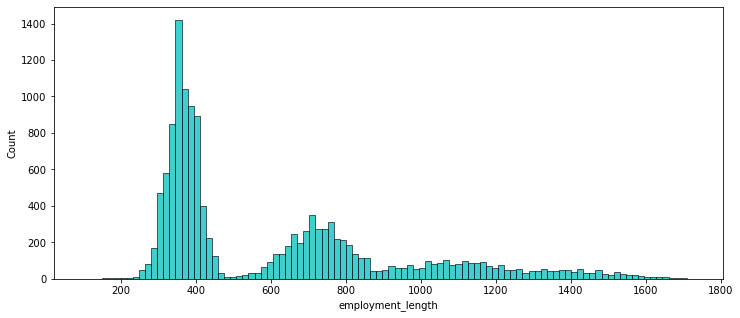

In [162]:
fig = plt.figure(figsize=(12,5))
sns.histplot(df['employment_length'],color = 'c',bins=100)

We can see from this histgram that, there are peaks around each employee year anniversary!!

<AxesSubplot:ylabel='Count'>

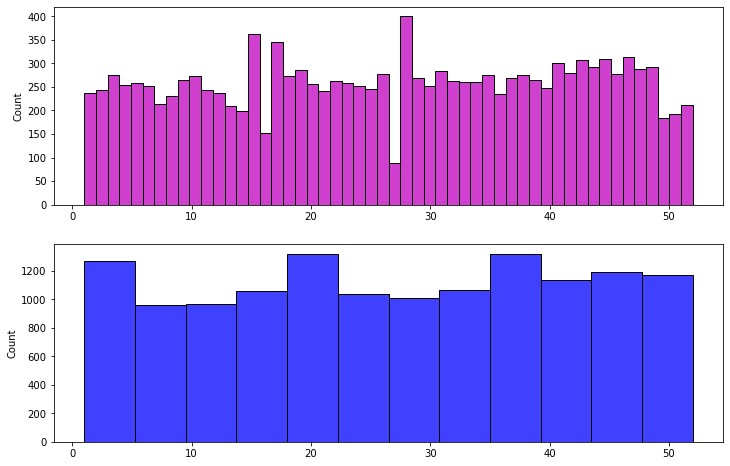

In [171]:
## Plot week of year and month of year
# Week No. for quiting
quit_data = df[~df['quit_date'].isnull()]
import datetime
quit_week = np.array(list(map(lambda x: x.week, quit_data['quit_date'])))
quit_month = np.array(list(map(lambda x: x.month, quit_data['quit_date'])))
# plot employee length in weeks
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
sns.histplot(quit_week, bins=len(np.unique(quit_week)), color= 'm',ax=ax[0])
sns.histplot(quit_week, bins=len(np.unique(quit_month)), color= 'b',ax=ax[1])

We can see there is no big difference among the week-of-year or month-of-year!

### 3. find the characteristics of the people who quit early

By looking at the histogram of employment_length, it looks like we could define early quitters as those people who quit within 1 year or so. So, we can create two classes of users： quit within 13 months or not. 

And for those people who hasn't been in the current company for at least 13 months, we remove them.

In [172]:
data = df[df['join_date']<(pd.to_datetime('2015-12-31')-pd.DateOffset(365 + 31))]

In [173]:
early_quitters = []
for i in range(data.shape[0]):
    if data['quit_date'].iloc[i]==None:
        early_quitters.append(0)
    elif (data['quit_date'].iloc[i] - data['join_date'].iloc[i]).days>(365 + 31):
        early_quitters.append(0)
    else:
        early_quitters.append(1)

In [174]:
data['early_quitters'] = early_quitters

C:\Users\yijia\AppData\Local\Temp/ipykernel_7248/3317096494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['early_quitters'] = early_quitters


In [175]:
#=================================================
#Decision Tree 1
#=================================================
X = data[['employee_id', 'company_id', 'seniority','salary']]
y = data['early_quitters']

In [176]:
dept = pd.get_dummies(data['dept'],drop_first=True)

In [180]:
X = pd.concat([X, dept], axis=1)

In [182]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=42)
clf = clf.fit(X=X , y=y)

In [183]:
# Feature importance
features = list(X.columns)
targets = ['Not quit', 'Quit']
importance = sorted(zip(features, clf.feature_importances_), key=lambda x:x[1], reverse=True)
for feature, val in importance:
    print('{0:10s} | {1:.5f}'.format(feature, val))

salary     | 0.95678
employee_id | 0.04322
company_id | 0.00000
seniority  | 0.00000
data_science | 0.00000
design     | 0.00000
engineer   | 0.00000
marketing  | 0.00000
sales      | 0.00000


In [185]:
from sklearn import tree
text_representation = tree.export_text(clf)
print(text_representation)

|--- feature_3 <= 224500.00
|   |--- feature_3 <= 62500.00
|   |   |--- feature_0 <= 53758.00
|   |   |   |--- class: 0
|   |   |--- feature_0 >  53758.00
|   |   |   |--- class: 0
|   |--- feature_3 >  62500.00
|   |   |--- feature_3 <= 182500.00
|   |   |   |--- class: 0
|   |   |--- feature_3 >  182500.00
|   |   |   |--- class: 0
|--- feature_3 >  224500.00
|   |--- feature_3 <= 274500.00
|   |   |--- feature_0 <= 746825.00
|   |   |   |--- class: 0
|   |   |--- feature_0 >  746825.00
|   |   |   |--- class: 0
|   |--- feature_3 >  274500.00
|   |   |--- feature_3 <= 339500.00
|   |   |   |--- class: 0
|   |   |--- feature_3 >  339500.00
|   |   |   |--- class: 0



Not surprising! Salary is what matters the most. After all, it probably has within it information about the other variables too. That is, seniority, dept and company impact salary. So salary carries pretty much all the information available.

we can see, if salary between 62500 and 224500, the employee has higher probability of being an early quitter, otherwise not. That means tha tpeople who make a lot of money an dvery little are not likely to quit

C:\Users\yijia\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\yijia\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


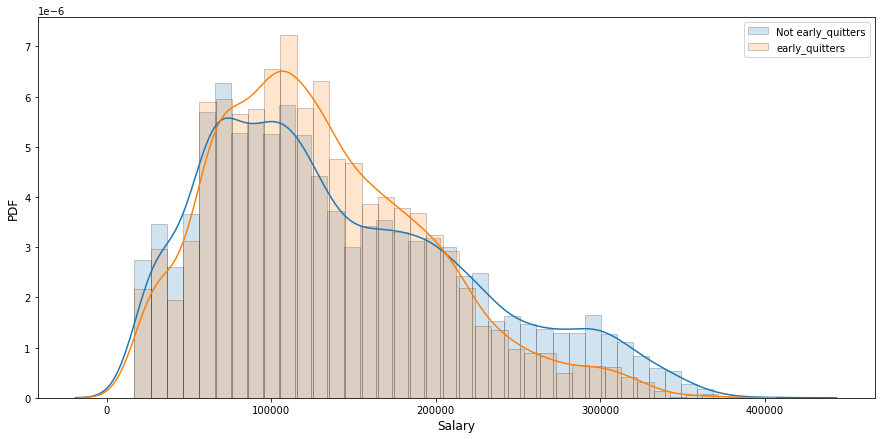

In [186]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 7))
sns.distplot(data[data['early_quitters']==0]['salary'], 
             label='Not early_quitters', ax=ax, hist_kws=hist_kws)
sns.distplot(data[data['early_quitters']==1]['salary'], 
             label='early_quitters', ax=ax, hist_kws=hist_kws)
ax.set_xlabel('Salary', fontsize=12)
ax.set_ylabel('PDF', fontsize=12)
ax.legend()
plt.show()

### Conclusion

1. Given how important is salary, I would definitely love to have as a variable the salary the employee who quit was offered in the next job. Otherwise, things like: promotions or raises received during the employee tenure would be interesting.

2. The major findings are that employees quit at year anniversaries, this makes sense. Even if you don’t like your current job, you often stay for 1 yr before quitting + you often get stocks after 1 yr so it makes sense to wait. Also, the beginning of the year is well known to be the best time to change job: companies are hiring more and you often want to stay until end of Dec to get the calendar year bonus.

3. Employees with low and high salaries are less likely to quit. Probably because employees with high salaries are happy there and employees with low salaries are not that marketable, so they have a hard time finding a new job.